In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [58]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 7216462#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

2275488
Title: Technological innovations that we will see in 2021 - 15 min
Description: Artificial intelligence, virtual and augmented reality, the Internet of Things, robotics, automation... For almost five years, reviews of future technologies have been starting...
Original Language: Lithuanian


In [59]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Technological innovations that we will see in 2021 - 15 min
Description: Artificial intelligence, virtual and augmented reality, the Internet of Things, robotics, automation... For almost five years, reviews of future technologies have been starting...
Original Language: Lithuanian
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words

In [60]:
##############################################
motivation_raw = '''
{
    "introduction": "As we dive into the era of technological advancements, it's fascinating to consider how these innovations have evolved over the years. By gathering data on the development and adoption rates of artificial intelligence, virtual reality, and the Internet of Things, we can create a vivid picture of their growth trends and future potential. This exploration will highlight which technologies are becoming integral parts of our daily lives and how rapidly they are being embraced worldwide.",
    "title": "Evolving_Tech_Trends_and_Adoption_Rates_2021"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [61]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [64]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
    {
        "name": "Public Adoption of New Technologies",
        "description": "The extent to which the public adopts new technologies like AI, VR, and IoT.",
        "type": "outcome",
        "observed": true,
        "values": ["Low Adoption", "High Adoption"],
        "parents": ["Investment in Tech Research", "Accessibility of Technology", "Tech Media Coverage"]
    },
    {
        "name": "Investment in Tech Research",
        "description": "Financial and resource investment in technology research and development.",
        "type": "treatment",
        "observed": true,
        "values": ["Low Investment", "High Investment"],
        "parents": ["Government Policy on Tech Innovation", "Economic Stability"]
    },
    {
        "name": "Government Policy on Tech Innovation",
        "description": "Government policies supporting or regulating technological innovations.",
        "type": "treatment",
        "observed": true,
        "values": ["Restrictive Policy", "Supportive Policy"],
        "parents": ["Economic Stability", "Public Interest in Technology"]
    },
    {
        "name": "Economic Stability",
        "description": "The overall economic stability of a region or country.",
        "type": "confounder",
        "observed": true,
        "values": ["Unstable Economy", "Stable Economy"],
        "parents": []
    },
    {
        "name": "Public Interest in Technology",
        "description": "The level of public interest and enthusiasm for new technological advancements.",
        "type": "confounder",
        "observed": true,
        "values": ["Low Interest", "High Interest"],
        "parents": []
    },
    {
        "name": "Accessibility of Technology",
        "description": "The ease with which the general public can access and use new technologies.",
        "type": "mediator",
        "observed": true,
        "values": ["Low Accessibility", "High Accessibility"],
        "parents": ["Investment in Tech Research", "Government Policy on Tech Innovation"]
    },
    {
        "name": "Tech Media Coverage",
        "description": "The extent and nature of media coverage on new technologies.",
        "type": "mediator",
        "observed": true,
        "values": ["Limited Coverage", "Extensive Coverage"],
        "parents": ["Public Interest in Technology"]
    },
    {
        "name": "Rate of Tech Industry Growth",
        "description": "The rate at which the technology industry is growing in a region or globally.",
        "type": "collider",
        "observed": true,
        "values": ["Slow Growth", "Rapid Growth"],
        "parents": ["Economic Stability", "Public Adoption of New Technologies"]
    }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

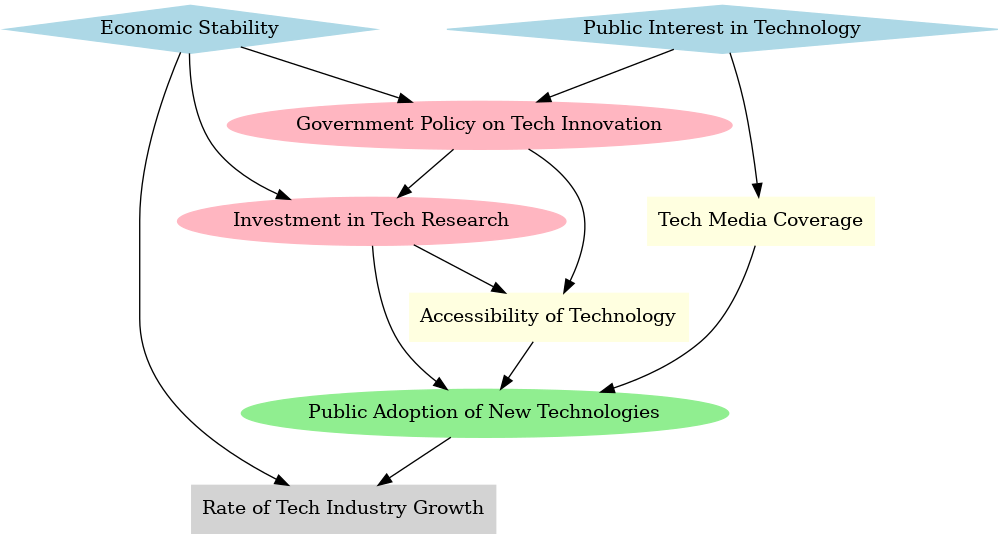

In [65]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [66]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

As we dive into the era of technological advancements, it's fascinating to consider how these innovations have evolved over the years. By gathering data on the development and adoption rates of artificial intelligence, virtual reality, and the Internet of Things, we can create a vivid picture of their growth trends and future potential. This exploration will highlight which technologies are becoming integral parts of our daily lives and how rapidly they are being embraced worldwide.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (

In [67]:
#################################################

structure_raw = '''
[
    {
        "sentence": "Interestingly, the growth of the technology industry is influenced not only by how quickly new technologies like AI and VR are adopted by the public but also by the overall economic stability of a region or country.",
        "involved": ["Rate of Tech Industry Growth", "Public Adoption of New Technologies", "Economic Stability"]
    },
    {
        "sentence": "The extent to which the public embraces new technologies is shaped by how easily they can access these technologies and the nature of media coverage they receive.",
        "involved": ["Public Adoption of New Technologies", "Accessibility of Technology", "Tech Media Coverage"]
    },
    {
        "sentence": "Government policies on tech innovation play a crucial role, being influenced by both the economic stability of a region and the public's interest in technology.",
        "involved": ["Government Policy on Tech Innovation", "Economic Stability", "Public Interest in Technology"]
    },
    {
        "sentence": "The financial and resource investment in technology research is not only a matter of economic stability but also depends on the government's stance towards technology innovation.",
        "involved": ["Investment in Tech Research", "Economic Stability", "Government Policy on Tech Innovation"]
    },
    {
        "sentence": "How easily the public can access and use new technologies is directly affected by the level of investment in tech research and the supportive or restrictive nature of government policies.",
        "involved": ["Accessibility of Technology", "Investment in Tech Research", "Government Policy on Tech Innovation"]
    },
    {
        "sentence": "The way media covers technological advancements is significantly swayed by the public's interest in these new technologies.",
        "involved": ["Tech Media Coverage", "Public Interest in Technology"]
    },
    {
        "sentence": "The economic stability of a region plays a foundational role, impacting not just investment in tech research but also influencing government policies on technological innovation.",
        "involved": ["Economic Stability", "Investment in Tech Research", "Government Policy on Tech Innovation"]
    },
    {
        "sentence": "Public interest in technology not only shapes government policies but also determines how technology is portrayed in the media, further influencing public adoption.",
        "involved": ["Public Interest in Technology", "Government Policy on Tech Innovation", "Tech Media Coverage"]
    }
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [68]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

As we dive into the era of technological advancements, it's fascinating to consider how these innovations have evolved over the years. By gathering data on the development and adoption rates of artificial intelligence, virtual reality, and the Internet of Things, we can create a vivid picture of their growth trends and future potential. This exploration will highlight which technologies are becoming integral parts of our daily lives and how rapidly they are being embraced worldwide.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Economic Stability" is "Stable Economy" (rather than "Unstable Economy")?
2. what is the probability that "Public Interest in Technology" is "High Interest" (rather than "Low Interest")?
3. when "Economic Stability" is "Unstable Economy" and "P

In [69]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.6, 0.8],
  "2": [0.7, 0.9],
  "3": [0.1, 0.3],
  "4": [0.4, 0.6],
  "5": [0.5, 0.7],
  "6": [0.8, 0.9],
  "7": [0.2, 0.4],
  "8": [0.4, 0.6],
  "9": [0.5, 0.7],
  "10": [0.7, 0.9],
  "11": [0.2, 0.3],
  "12": [0.4, 0.5],
  "13": [0.6, 0.7],
  "14": [0.8, 0.9],
  "15": [0.3, 0.4],
  "16": [0.7, 0.8],
  "17": [0.1, 0.2],
  "18": [0.3, 0.4],
  "19": [0.4, 0.5],
  "20": [0.6, 0.7],
  "21": [0.5, 0.6],
  "22": [0.7, 0.8],
  "23": [0.7, 0.8],
  "24": [0.9, 1.0],
  "25": [0.2, 0.3],
  "26": [0.6, 0.7],
  "27": [0.4, 0.5],
  "28": [0.8, 0.9]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [70]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions)#.item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

------------------------------------  ------------------  -----------------  ----------------------------------------------------------------------------
Government Policy on Tech Innovation  Restrictive Policy  Supportive Policy  Government policies supporting or regulating technological innovations.
Investment in Tech Research           Low Investment      High Investment    Financial and resource investment in technology research and development.
Public Adoption of New Technologies   Low Adoption        High Adoption      The extent to which the public adopts new technologies like AI, VR, and IoT.
------------------------------------  ------------------  -----------------  ----------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Economic Stability' means The overall economic stability of a region or country.
'Public Interest in Technology' means The level of public interest and enthusiasm for new technological advancements.
'Government Policy on Tech Innovation' means Government policies supporting or regulating technological innovations.
'Investment in Tech Research' means Financial and resource investment in technology research and development.
'Accessibility of Technology' means The ease with which the general public can access and use new technologies.
'Tech Media Coverage' means The extent and nature of media coverage on new technologies.
'Public Adoption of New Technologies' means The extent to which the public adopts new technologies like AI, VR, and IoT.
'Rate of Tech Industry Growth' means The rate at which the technology industry is growing in a region or globally.
Treatment Value    Treatment                             Outcome Value    Outcome                                   ATE    Correlation
-

AttributeError: 'float' object has no attribute 'item'

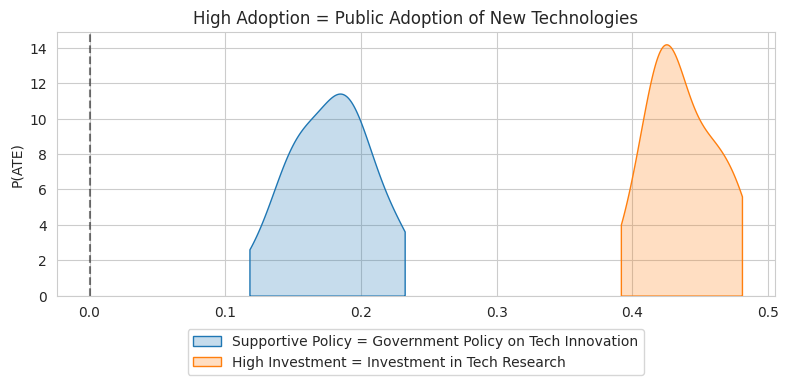

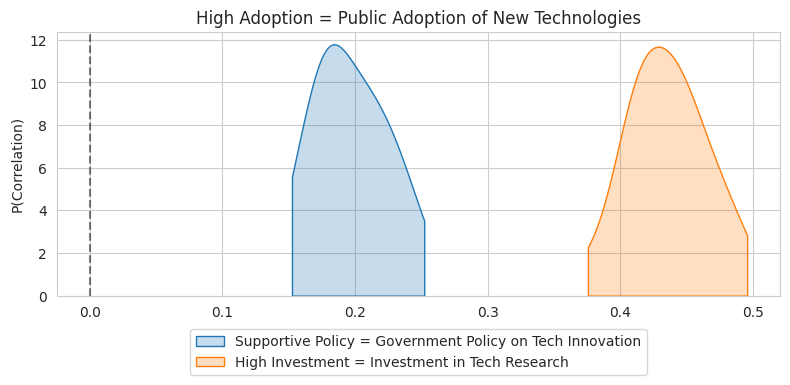

In [71]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [72]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Economic Stability' (0='Unstable Economy', 1='Stable Economy') means The overall economic stability of a region or country.
Variable 'Public Interest in Technology' (0='Low Interest', 1='High Interest') means The level of public inter

In [73]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Economic Stability": {
    "descriptor": ["the economic stability", "financial steadiness of the region", "economic climate"],
    "subject": "the region",
    "predicate0": ["experiences economic fluctuations", "faces financial instability"],
    "predicate1": ["enjoys economic stability", "maintains a stable economy"],
    "pronoun": "it",
    "nounclause0": ["the region's economy is unstable", "there is economic uncertainty in the area"],
    "nounclause1": ["the region's economy is stable", "there is financial stability in the area"],
    "preposition": ["in", "within"],
    "domain": "regions",
    "subclause0": ["economic stability is lacking", "financial steadiness is not present"],
    "subclause1": ["economic stability is evident", "financial steadiness is maintained"],
    "condition0": ["in an unstable economy", "if the economic climate is shaky"],
    "condition1": ["in a stable economy", "if the economic climate is steady"],
    "action0": ["the economy becomes unstable", "financial stability deteriorates"],
    "action1": ["the economy stabilizes", "financial stability is achieved"]
  },
  "Public Interest in Technology": {
    "descriptor": ["public interest in technology", "public enthusiasm for tech advancements", "public engagement with technology"],
    "subject": "people",
    "predicate0": ["show limited interest in technology", "are not keen on tech advancements"],
    "predicate1": ["are highly interested in technology", "are enthusiastic about tech advancements"],
    "pronoun": "they",
    "nounclause0": ["people have a low interest in technology", "there's little enthusiasm for tech among the public"],
    "nounclause1": ["people are highly interested in technology", "there's a high level of tech enthusiasm among the public"],
    "preposition": ["among", "within"],
    "domain": "the public",
    "subclause0": ["interest in technology is minimal", "enthusiasm for tech is low"],
    "subclause1": ["interest in technology is high", "enthusiasm for tech is strong"],
    "condition0": ["if public interest in technology is low", "when people are not engaged with tech advancements"],
    "condition1": ["if public interest in technology is high", "when people are actively engaged with tech advancements"],
    "action0": ["public interest in technology decreases", "public engagement with tech diminishes"],
    "action1": ["public interest in technology grows", "public engagement with tech increases"]
  },
  "Government Policy on Tech Innovation": {
    "descriptor": ["governmental stance on tech innovation", "policy approach towards technology", "regulatory environment for tech"],
    "subject": "the government",
    "predicate0": ["implements restrictive tech policies", "regulates technology strictly"],
    "predicate1": ["supports technological innovation", "fosters a tech-friendly environment"],
    "pronoun": "it",
    "nounclause0": ["government policies restrict tech innovation", "there are strict regulations on technology"],
    "nounclause1": ["government policies support tech innovation", "there's a supportive environment for technology"],
    "preposition": ["under", "with"],
    "domain": "policies",
    "subclause0": ["a restrictive stance on technology is taken", "tech innovation is regulated strictly"],
    "subclause1": ["a supportive stance on technology is taken", "tech innovation is encouraged"],
    "condition0": ["when the government restricts technology", "if tech policies are stringent"],
    "condition1": ["when the government supports technology", "if tech policies are encouraging"],
    "action0": ["government tightens tech regulations", "tech policies become more restrictive"],
    "action1": ["government loosens tech regulations", "tech policies become more supportive"]
  },
  "Investment in Tech Research": {
    "descriptor": ["investment in technology research", "funding for tech development", "financial support for tech innovation"],
    "subject": "the industry",
    "predicate0": ["sees minimal investment in research", "receives limited funding for development"],
    "predicate1": ["benefits from high investment in research", "enjoys generous funding for development"],
    "pronoun": "it",
    "nounclause0": ["investment in tech research is low", "funding for tech development is scarce"],
    "nounclause1": ["investment in tech research is high", "funding for tech development is abundant"],
    "preposition": ["with", "in"],
    "domain": "the tech sector",
    "subclause0": ["resources for tech research are limited", "financial backing for development is minimal"],
    "subclause1": ["resources for tech research are ample", "financial backing for development is substantial"],
    "condition0": ["if investment in tech research is low", "when funding for tech development is scarce"],
    "condition1": ["if investment in tech research is high", "when funding for tech development is abundant"],
    "action0": ["investment in tech research decreases", "funding for tech development reduces"],
    "action1": ["investment in tech research increases", "funding for tech development expands"]
  },
  "Accessibility of Technology": {
    "descriptor": ["accessibility of technology", "ease of tech use", "public access to technology"],
    "subject": "technology",
    "predicate0": ["is not easily accessible", "remains hard to use for many"],
    "predicate1": ["is highly accessible", "can be used easily by most"],
    "pronoun": "it",
    "nounclause0": ["technology is hard to access", "using tech is challenging for the public"],
    "nounclause1": ["technology is easily accessible", "using tech is straightforward for the public"],
    "preposition": ["in terms of", "regarding"],
    "domain": "usage",
    "subclause0": ["access to technology is limited", "tech remains challenging to use"],
    "subclause1": ["access to technology is widespread", "tech is user-friendly and accessible"],
    "condition0": ["when technology is not easily accessible", "if public access to tech is limited"],
    "condition1": ["when technology is highly accessible", "if public access to tech is widespread"],
    "action0": ["accessibility of technology decreases", "tech becomes harder to use"],
    "action1": ["accessibility of technology increases", "tech becomes easier to use"]
  },
  "Tech Media Coverage": {
    "descriptor": ["media coverage of technology", "tech reporting in the media", "public exposure to tech news"],
    "subject": "the media",
    "predicate0": ["gives limited coverage to technology", "reports minimally on tech"],
    "predicate1": ["extensively covers technology", "reports widely on tech"],
    "pronoun": "it",
    "nounclause0": ["technology receives limited media coverage", "tech news is not widely reported"],
    "nounclause1": ["technology receives extensive media coverage", "tech news is widely reported"],
    "preposition": ["in", "across"],
    "domain": "media outlets",
    "subclause0": ["limited reporting on technology is seen", "tech topics are rarely highlighted"],
    "subclause1": ["extensive reporting on technology is seen", "tech topics are frequently highlighted"],
    "condition0": ["when tech media coverage is limited", "if technology is not widely reported"],
    "condition1": ["when tech media coverage is extensive", "if technology is widely reported"],
    "action0": ["media coverage of technology is reduced", "reporting on tech becomes scarce"],
    "action1": ["media coverage of technology is increased", "reporting on tech becomes widespread"]
  },
  "Public Adoption of New Technologies": {
    "descriptor": ["adoption of new technologies by the public", "public uptake of tech innovations", "public engagement with new tech"],
    "subject": "the public",
    "predicate0": ["is slow to adopt new technologies", "shows little uptake of tech innovations"],
    "predicate1": ["quickly adopts new technologies", "eagerly engages with tech innovations"],
    "pronoun": "they",
    "nounclause0": ["new technologies are not widely adopted by the public", "there is low engagement with tech innovations"],
    "nounclause1": ["new technologies are widely adopted by the public", "there is high engagement with tech innovations"],
    "preposition": ["among", "within"],
    "domain": "the population",
    "subclause0": ["public adoption of new tech is low", "uptake of tech innovations among the public is minimal"],
"subclause1": ["public adoption of new tech is high", "uptake of tech innovations among the public is widespread"],
"condition0": ["if the public is slow to adopt new technologies", "when there's little public engagement with tech"],
"condition1": ["if the public quickly adopts new technologies", "when there's high public engagement with tech"],
"action0": ["public adoption of new technologies decreases", "public engagement with tech reduces"],
"action1": ["public adoption of new technologies increases", "public engagement with tech grows"]
},
"Rate of Tech Industry Growth": {
"descriptor": ["growth rate of the tech industry", "pace of tech industry expansion", "tech sector's growth velocity"],
"subject": "the tech industry",
"predicate0": ["experiences slow growth", "expands at a sluggish pace"],
"predicate1": ["experiences rapid growth", "expands at a fast pace"],
"pronoun": "it",
"nounclause0": ["the tech industry's growth is slow", "there's a sluggish pace of expansion in tech"],
"nounclause1": ["the tech industry's growth is rapid", "there's a fast pace of expansion in tech"],
"preposition": ["at", "within"],
"domain": "the industry",
"subclause0": ["slow growth is seen in the tech sector", "the expansion pace in tech is sluggish"],
"subclause1": ["rapid growth is seen in the tech sector", "the expansion pace in tech is fast"],
"condition0": ["when the tech industry grows slowly", "if the expansion pace in tech is sluggish"],
"condition1": ["when the tech industry grows rapidly", "if the expansion pace in tech is fast"],
"action0": ["the growth rate of the tech industry slows down", "expansion in the tech sector becomes sluggish"],
"action1": ["the growth rate of the tech industry speeds up", "expansion in the tech sector becomes rapid"]
}
}


'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)
assert all(node['name'] in ctx['verbs'] for node in nodes)

In [74]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

As we dive into the era of technological advancements, it's fascinating to consider how these innovations have evolved over the years. By gathering data on the development and adoption rates of artificial intelligence, virtual reality, and the Internet of Things, we can create a vivid picture of their growth trends and future potential. This exploration will highlight which technologies are becoming integral parts of our daily lives and how rapidly they are being embraced worldwide.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Government Policy on Tech Innovation') > 0
	2. ATE('Investment in Tech Research') < 0
	3. ATE('Investment in Tech Research') > ATE('Government Policy on Tech Innovation')
	4. |ATE('Government Policy on Tech Innovation')| > 

In [75]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Does supportive government policy on tech innovation have a positive impact on the adoption of new technologies?",
        "answer": "yes",
        "claim": "Supportive government policies on tech innovation positively influence the adoption of new technologies."
    },
    "2": {
        "question": "Does a decrease in investment in tech research negatively affect the adoption of new technologies?",
        "answer": "yes",
        "claim": "A decrease in investment in tech research leads to a negative impact on the adoption of new technologies."
    },
    "3": {
        "question": "Is the impact of investment in tech research on new technology adoption greater than that of government policy on tech innovation?",
        "answer": "yes",
        "claim": "Investment in tech research has a greater impact on new technology adoption than government policy on tech innovation."
    },
    "4": {
        "question": "Is the absolute impact of government policy on tech innovation on new technology adoption greater than that of investment in tech research?",
        "answer": "yes",
        "claim": "The absolute impact of government policy on tech innovation on new technology adoption is greater than that of investment in tech research."
    },
    "5": {
        "question": "In an unstable economy, does supportive government policy on tech innovation negatively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "In an unstable economy, supportive government policy on tech innovation has a negative influence on the adoption of new technologies."
    },
    "6": {
        "question": "In an unstable economy, does increased investment in tech research positively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "In an unstable economy, increased investment in tech research positively influences the adoption of new technologies."
    },
    "7": {
        "question": "In an unstable economy, is the positive impact of investment in tech research on new technology adoption greater than that of supportive government policy?",
        "answer": "yes",
        "claim": "In an unstable economy, investment in tech research has a greater positive impact on new technology adoption than supportive government policy."
    },
    "8": {
        "question": "In an unstable economy, is the absolute impact of investment in tech research on new technology adoption less than that of government policy on tech innovation?",
        "answer": "yes",
        "claim": "In an unstable economy, the absolute impact of investment in tech research on new technology adoption is less than that of government policy on tech innovation."
    },
    "9": {
        "question": "In a stable economy, does supportive government policy on tech innovation negatively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "In a stable economy, supportive government policy on tech innovation negatively influences the adoption of new technologies."
    },
    "10": {
        "question": "In a stable economy, does increased investment in tech research positively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "In a stable economy, increased investment in tech research positively influences the adoption of new technologies."
    },
    "11": {
        "question": "In a stable economy, is the positive impact of investment in tech research on new technology adoption greater than that of supportive government policy?",
        "answer": "yes",
        "claim": "In a stable economy, investment in tech research has a greater positive impact on new technology adoption than supportive government policy."
    },
    "12": {
        "question": "In a stable economy, is the absolute impact of investment in tech research on new technology adoption greater than that of government policy on tech innovation?",
        "answer": "yes",
        "claim": "In a stable economy, the absolute impact of investment in tech research on new technology adoption is greater than that of government policy on tech innovation."
    },
    "13": {
        "question": "Is the influence of government policy on tech innovation on new technology adoption stronger in a stable economy than in an unstable one?",
        "answer": "yes",
        "claim": "Government policy on tech innovation has a stronger influence on new technology adoption in a stable economy compared to an unstable one."
    },
    "14": {
        "question": "Is the absolute influence of government policy on tech innovation on new technology adoption greater in a stable economy than in an unstable one?",
        "answer": "yes",
        "claim": "The absolute influence of government policy on tech innovation on new technology adoption is greater in a stable economy than in an unstable one."
    },
    "15": {
        "question": "Is the influence of investment in tech research on new technology adoption weaker in a stable economy than in an unstable one?",
        "answer": "yes",
        "claim": "Investment in tech research has a weaker influence on new technology adoption in a stable economy compared to an unstable one."
    },
    "16": {
        "question": "In an unstable economy, is the absolute impact of investment in tech research on new technology adoption greater than in a stable economy?",
        "answer": "yes",
        "claim": "The absolute impact of investment in tech research on new technology adoption is greater in an unstable economy than in a stable one."
    },
    "17": {
        "question": "With low public interest in technology, does supportive government policy on tech innovation negatively affect the adoption of new technologies?",
        "answer": "yes",
        "claim": "When public interest in technology is low, supportive government policy on tech innovation negatively affects the adoption of new technologies."
    },
    "18": {
        "question": "With low public interest in technology, does increased investment in tech research negatively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "When public interest in technology is low, increased investment in tech research negatively influences the adoption of new technologies."
    },
    "19": {
        "question": "With low public interest in technology, is the impact of investment in tech research on new technology adoption greater than that of government policy?",
        "answer": "yes",
        "claim": "With low public interest in technology, investment in tech research has a greater impact on new technology adoption than government policy."
    },
    "20": {
        "question": "With low public interest in technology, is the absolute impact of government policy on tech innovation less than that of investment in tech research?",
        "answer": "yes",
        "claim": "With low public interest in technology, the absolute impact of government policy on tech innovation is less than that of investment in tech research."
    },
    "21": {
        "question": "With high public interest in technology, does supportive government policy on tech innovation positively affect the adoption of new technologies?",
        "answer": "yes",
        "claim": "When public interest in technology is high, supportive government policy on tech innovation positively affects the adoption of new technologies."
    },
    "22": {
        "question": "With high public interest in technology, does increased investment in tech research negatively influence the adoption of new technologies?",
        "answer": "yes",
        "claim": "When public interest in technology is high, increased investment in tech research negatively influences the adoption of new technologies."
    },
    "23": {
        "question": "With high public interest in technology, is the impact of investment in tech research on new technology adoption greater than that of government policy?",
        "answer": "yes",
        "claim": "With high public interest in technology, investment in tech research has a greater impact on new technology adoption than government policy."
    },
    "24": {
        "question": "With high public interest in technology, is the absolute impact of government policy on tech innovation less than that of investment in tech research?",
        "answer": "yes",
        "claim": "With high public interest in technology, the absolute impact of government policy on tech innovation is less than that of investment in tech research."
    },
    "25": {
        "question": "Is the influence of government policy on tech innovation on new technology adoption stronger when public interest in technology is high compared to when it's low?",
        "answer": "yes",
        "claim": "Government policy on tech innovation has a stronger influence on new technology adoption when public interest in technology is high compared to when it's low."
},
"26": {
"question": "With high public interest in technology, is the absolute influence of government policy on tech innovation on new technology adoption greater than with low public interest?",
"answer": "yes",
"claim": "The absolute influence of government policy on tech innovation on new technology adoption is greater when public interest in technology is high compared to when it's low."
},
"27": {
"question": "Is the impact of investment in tech research on new technology adoption greater when public interest in technology is high compared to when it's low?",
"answer": "yes",
"claim": "Investment in tech research has a greater impact on new technology adoption when public interest in technology is high compared to when it's low."
},
"28": {
"question": "With low public interest in technology, is the absolute impact of investment in tech research on new technology adoption less than with high public interest?",
"answer": "yes",
"claim": "The absolute impact of investment in tech research on new technology adoption is less when public interest in technology is low compared to when it's high."
}
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [76]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Evolving_Tech_Trends_and_Adoption_Rates_2021.json'